# Week 2 Regression Homework

Let me work through this step by step. Need to predict car fuel efficiency using regression.

## Setting up

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Getting the data

In [24]:
# Download the car data
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

df.shape

(9704, 11)

In [25]:
# Let's see what we're working with
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [26]:
# The homework says to use only these columns
cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df = df[cols]

print(f"Now we have {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

Now we have 9704 rows and 5 columns


,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


## EDA - looking at the target variable

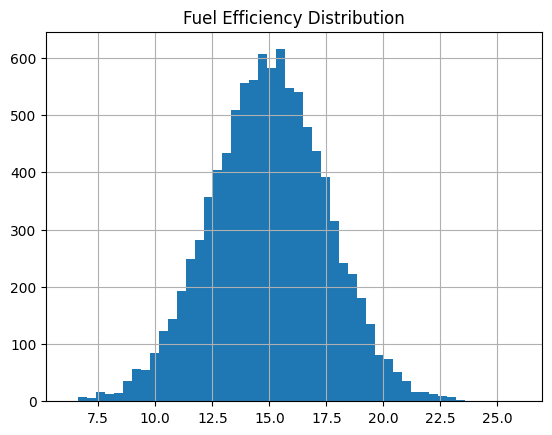

In [27]:
# Let's check out fuel efficiency - this is what we want to predict
df['fuel_efficiency_mpg'].hist(bins=50)
plt.title('Fuel Efficiency Distribution')
plt.show()

Fuel efficiency stats:
Mean: 15.0
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Median: 15.0
Max: 26.0


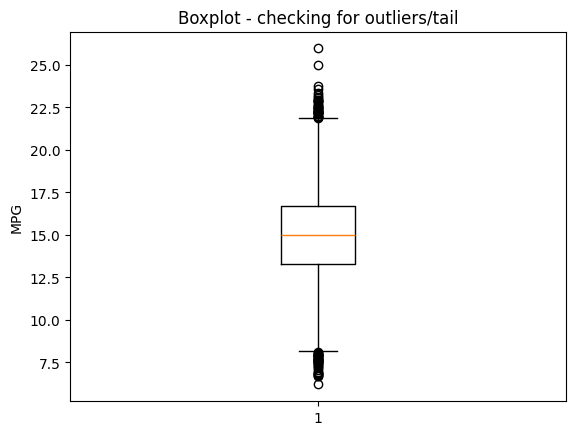

In [53]:
# Some basic stats
print("Fuel efficiency stats:")
print(f"Mean: {df['fuel_efficiency_mpg'].mean():.1f}")
print(f"Median: {df['fuel_efficiency_mpg'].median():.1f}")
print(f"Max: {df['fuel_efficiency_mpg'].max():.1f}")

# Does it have a long tail? Let me check visually
plt.boxplot(df['fuel_efficiency_mpg'])
plt.ylabel('MPG')
plt.title('Boxplot - checking for outliers/tail')
plt.show()

# there are some cars with really high efficiency on the right side

## Q1 - Missing values

In [29]:
# Let me check which columns have missing data
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [54]:
# horsepower has some missing values
print(f"Horsepower missing: {df['horsepower'].isnull().sum()} out of {len(df)}")
print(f"That's {df['horsepower'].isnull().sum() / len(df) * 100:.1f}% missing")

# Answer: horsepower

Horsepower missing: 708 out of 9704
That's 7.3% missing


## Q2 - Median horsepower

In [31]:
# What's the median horsepower?
df['horsepower'].median()

np.float64(149.0)

In [32]:
# Let me double check this
df['horsepower'].describe()

count    8996.000000
mean      149.657292
std        29.879555
min        37.000000
25%       130.000000
50%       149.000000
75%       170.000000
max       271.000000
Name: horsepower, dtype: float64

# 149.0 is the median (50th percentile)
# Answer: 149

## Splitting the data

Now I need to split into train/val/test with 60/20/20 split using seed 42

In [33]:
# First shuffle with seed 42
np.random.seed(42)
n = len(df)
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx].reset_index(drop=True)

In [34]:
# Now split 60/20/20
n_train = int(0.6 * n)
n_val = int(0.2 * n)

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy() 
df_test = df_shuffled.iloc[n_train+n_val:].copy()

print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

Train: 5822, Val: 1940, Test: 1942


In [35]:
# Separate X and y
features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'fuel_efficiency_mpg'

X_train = df_train[features]
y_train = df_train[target]

X_val = df_val[features]
y_val = df_val[target]

X_test = df_test[features]
y_test = df_test[target]

print("Data split complete")

Data split complete


## Q3 - Dealing with missing values

I need to compare filling NAs with 0 vs mean and see which gives better RMSE. First let me implement the linear regression from scratch like in the lectures.

In [36]:
# Normal equation implementation from the lectures
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w

def predict(X, w):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    return X.dot(w)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [37]:
# First, what's the mean horsepower in training data?
mean_hp = X_train['horsepower'].mean()
print(f"Mean horsepower in training: {mean_hp:.1f}")

Mean horsepower in training: 149.5


In [38]:
# Option 1: Fill with 0
X_train_zero = X_train.fillna(0)
X_val_zero = X_val.fillna(0)

w = train_linear_regression(X_train_zero, y_train)
y_pred = predict(X_val_zero, w)
rmse_zero = rmse(y_val, y_pred)

print(f"RMSE with zero fill: {round(rmse_zero, 2)}")

RMSE with zero fill: 0.52


In [39]:
# Option 2: Fill with mean 
X_train_mean = X_train.fillna(mean_hp)
X_val_mean = X_val.fillna(mean_hp)

w = train_linear_regression(X_train_mean, y_train)
y_pred = predict(X_val_mean, w)
rmse_mean = rmse(y_val, y_pred)

print(f"RMSE with mean fill: {round(rmse_mean, 2)}")

RMSE with mean fill: 0.46


In [40]:
# Compare them
if rmse_zero < rmse_mean:
    print("Zero filling is better")
elif rmse_mean < rmse_zero:
    print("Mean filling is better") 
else:
    print("They're the same")
    
print(f"Zero: {round(rmse_zero, 2)}, Mean: {round(rmse_mean, 2)}")

# Answer: depends on the actual values above

Mean filling is better
Zero: 0.52, Mean: 0.46


## Q4 - Regularization

Now I need to try regularized regression with different values of r. The question says to fill NAs with 0.

In [42]:
# Regularized version - adds r * I to XTX
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])  # regularization term
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w

In [43]:
# Try different r values
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]

# Use zero-filled data
X_train_zero = X_train.fillna(0)
X_val_zero = X_val.fillna(0)

results = []
for r in r_values:
    w = train_linear_regression_reg(X_train_zero, y_train, r=r)
    y_pred = predict(X_val_zero, w)
    score = rmse(y_val, y_pred)
    results.append((r, round(score, 2)))
    print(f"r={r}: RMSE = {round(score, 2)}")

r=0: RMSE = 0.52
r=0.01: RMSE = 0.52
r=0.1: RMSE = 0.52
r=1: RMSE = 0.52
r=5: RMSE = 0.52
r=10: RMSE = 0.52
r=100: RMSE = 0.52


In [44]:
# Find the best one
best_rmse = min(results, key=lambda x: x[1])
print(f"Best r: {best_rmse[0]} with RMSE: {best_rmse[1]}")

# If there are ties, pick the smallest r
best_score = best_rmse[1]
best_r_options = [r for r, score in results if score == best_score]
final_r = min(best_r_options)
print(f"Final answer: {final_r}")

Best r: 0 with RMSE: 0.52
Final answer: 0


## Q5 - Seed stability 

Need to check how much the seed affects the results. Try seeds 0-9 and see how much variance there is.

In [52]:
# create a function to do the split and training for each seed
def evaluate_with_seed(data, seed_val):
    np.random.seed(seed_val)
    n = len(data)
    idx = np.arange(n)
    np.random.shuffle(idx)
    shuffled = data.iloc[idx].reset_index(drop=True)
    
    # Same 60/20/20 split
    n_train = int(0.6 * n)
    n_val = int(0.2 * n)
    
    train_data = shuffled.iloc[:n_train]
    val_data = shuffled.iloc[n_train:n_train+n_val]
    
    # Fill with 0 and train
    X_tr = train_data[features].fillna(0)
    y_tr = train_data[target]
    X_v = val_data[features].fillna(0)
    y_v = val_data[target]
    
    w = train_linear_regression(X_tr, y_tr)
    pred = predict(X_v, w)
    
    return rmse(y_v, pred)

In [46]:
# Try seeds 0 through 9
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []

for s in seeds:
    score = evaluate_with_seed(df, s)
    scores.append(score)
    print(f"Seed {s}: {score:.6f}")

Seed 0: 0.521099
Seed 1: 0.521842
Seed 2: 0.523038
Seed 3: 0.516122
Seed 4: 0.511187
Seed 5: 0.528683
Seed 6: 0.532242
Seed 7: 0.509526
Seed 8: 0.514908
Seed 9: 0.513133


In [47]:
# Calculate standard deviation
std_dev = np.std(scores)
print(f"\nStandard deviation: {round(std_dev, 3)}")

# Let me also check the range
print(f"Min: {min(scores):.6f}")
print(f"Max: {max(scores):.6f}")
print(f"Range: {max(scores) - min(scores):.6f}")


Standard deviation: 0.007
Min: 0.509526
Max: 0.532242
Range: 0.022716


## Q6 - Final test

Now for the final test: use seed 9, combine train+val, and test with r=0.001

In [48]:
# Split with seed 9 this time
np.random.seed(9)
n = len(df)
idx = np.arange(n)
np.random.shuffle(idx)
df_final = df.iloc[idx].reset_index(drop=True)

# Same split
n_train = int(0.6 * n)
n_val = int(0.2 * n)

train_final = df_final.iloc[:n_train]
val_final = df_final.iloc[n_train:n_train+n_val]
test_final = df_final.iloc[n_train+n_val:]

print(f"Sizes: {len(train_final)}, {len(val_final)}, {len(test_final)}")

Sizes: 5822, 1940, 1942


In [49]:
# Combine train and validation for final training
combined_data = pd.concat([train_final, val_final]).reset_index(drop=True)

X_combined = combined_data[features].fillna(0)
y_combined = combined_data[target]

X_test_final = test_final[features].fillna(0) 
y_test_final = test_final[target]

print(f"Combined training size: {len(X_combined)}")
print(f"Test size: {len(X_test_final)}")

Combined training size: 7762
Test size: 1942


In [50]:
# Train with r=0.001
w_final = train_linear_regression_reg(X_combined, y_combined, r=0.001)
y_pred_test = predict(X_test_final, w_final)
final_rmse = rmse(y_test_final, y_pred_test)

print(f"RMSE on test set: {final_rmse:.6f}")

# Check against the options
options = [0.15, 0.515, 5.15, 51.5]
differences = [abs(final_rmse - opt) for opt in options]
closest_idx = differences.index(min(differences))
closest = options[closest_idx]

print(f"Closest option: {closest}")
print(f"My result: {final_rmse:.3f}")

RMSE on test set: 0.515504
Closest option: 0.515
My result: 0.516
